# Tutorial: data integration for unpaired BMMC data

In this tutorial, we demonstrate how to apply FGOT to integrate unpaired BMMC data. The original dataset can be download from GSE159417. After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/1ku9yfdUI1AExC-GflzEkU_F5bb8mbJ_f). 

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_4dim, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/BMMC_data/"
RNA_data = pd.read_csv(data_path+'RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'ATAC_normalized.txt', sep='\t', index_col=0)

In [4]:
cell1_cluster = pd.read_csv(data_path+"BMMC_RNA_label.txt", sep='\t')
cell2_cluster = pd.read_csv(data_path+"BMMC_agg_k5_atac_label.txt", sep='\t')
cell1_cluster = cell1_cluster.reset_index()
cell1_cluster = cell1_cluster.rename(columns={'index':'cell','x': 'cluster'})
cell2_cluster = cell2_cluster.reset_index()
cell2_cluster = cell2_cluster.rename(columns={'index':'cell','metas': 'cluster'})

In [5]:
X1 = RNA_data
X2 = ATAC_data
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(cell1_cluster['cluster'])
basic_labels2 = np.array(cell2_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(RNA_data.index)
cell_names2 = list(ATAC_data.index)
gene_names = list(RNA_data.columns)
peak_names = list(ATAC_data.columns)

Dimensions of input datasets are:  X1 =  (2379, 275)  X2 =  (1602, 6970)
Dimensions of basic_labels are:  basic_labels1 =  (2379,)  basic_labels2 =  (1602,)


## compute feature relationship

In [6]:
promoters = pd.read_csv(data_path+'hg19.promoter.regions.txt', sep = '\t',header=None)
promoters[3] = promoters[3].str.split('|').str[0]
promoters.rename(columns={0: 'chr', 1: 'starts', 2: 'ends', 3: 'genes'}, inplace=True)
promoters.head()

,chr,starts,ends,genes
0,chr1,11869,11870,DDX11L1
1,chr1,11872,11873,DDX11L1
2,chr1,11874,11875,DDX11L1
3,chr1,12010,12011,DDX11L1
4,chr1,24886,24887,WASH7P


In [7]:
feature_matrix = pre.prior_feature_graph(promoters, gene_names, peak_names)
feature_matrix

178865it [00:00, 366404.80it/s]
178865it [00:03, 52753.67it/s]
100%|██████████| 275/275 [00:00<00:00, 404.93it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 275 6970 8808


100%|██████████| 8808/8808 [00:00<00:00, 1534068.17it/s]


,chr19-36400046-36400793,chr1-167479681-167479740,chr22-23062530-23064843,chr5-131720959-131721533,chr12-122326159-122327317,chr12-111126484-111128080,chr20-3758014-3759070,chr6-138248816-138249806,chrX-47691174-47691565,chr16-31188379-31188959,...,chr2-86849670-86851375,chr17-76333437-76334283,chr1-228275590-228278006,chr2-86017556-86017963,chr3-108381020-108381418,chr14-75760332-75763216,chr19-2819497-2820437,chr1-151893976-151894426,chr17-76272306-76272944,chr12-111051357-111052374
TNFRSF25,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
EFHD2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
RCAN3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
LDLRAP1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
STMN1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALAS2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
ITM2A,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
SH2D1A,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
CD40LG,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost
Calculate the similarity between cells through MNN pairs between embedding RNA and gene activity score from scVI.

In [8]:
cell_Cor = pd.read_table(data_path+'cell_Cor_scVIlatent.txt',index_col=0)
cell_Cor

,Agg_atac_1-1,Agg_atac_2-1,Agg_atac_3-1,Agg_atac_4-1,Agg_atac_5-1,Agg_atac_6-1,Agg_atac_7-1,Agg_atac_8-1,Agg_atac_9-1,Agg_atac_10-1,...,Agg_atac_1593-1,Agg_atac_1594-1,Agg_atac_1595-1,Agg_atac_1596-1,Agg_atac_1597-1,Agg_atac_1598-1,Agg_atac_1599-1,Agg_atac_1600-1,Agg_atac_1601-1,Agg_atac_1602-1
AAACCTGAGCTTTGGT.1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCACAGGCCT.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGCCTTC.1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTGTGTGCC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGTCCGTCATC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGCCCAATT.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTCAAGTCACGCC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTCACACATCCAA.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGTCACAGGTCTCG.1,1,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# import snn
snn1 = pd.read_csv(data_path+"BMMC_rna_snn.txt", sep='\t',index_col=0)
snn2 = pd.read_csv(data_path+"BMMC_atac_gene_acitivity_snn_k5.txt", sep='\t',index_col=0)

In [10]:
S_new = pre.smooth_cell_similarity_byLaplacian2(cell_Cor,snn1,snn2)
S_new = S_new/np.max(S_new) + cell_Cor/np.max(cell_Cor)

In [11]:
# compute cost
cost = np.array(np.exp(np.max(S_new) - S_new))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

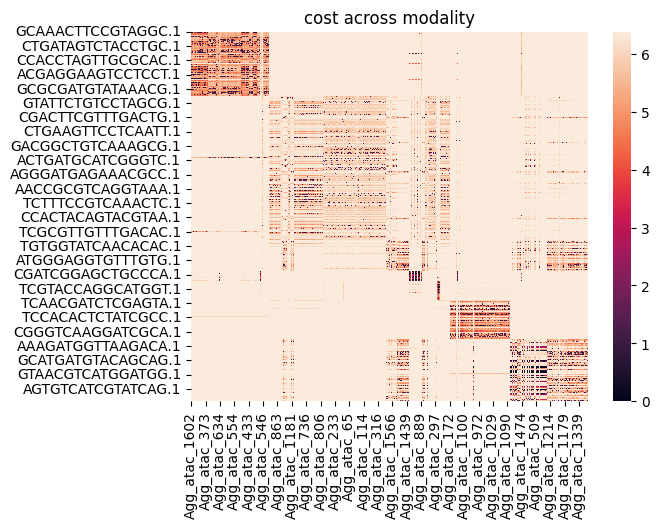

In [12]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_rows]
sns.heatmap(sorted_cost)
pl.title('cost across modality')

## scale

In [13]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=gene_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=peak_names)

## solve the feature-guided optimal transport

## fastMinibatch strategy

In [15]:
P_4dim = fgot_sparse_4dim(X1, X2, feature_matrix, cost, cell1_cluster, cell2_cluster,\
    minibatch=1, batchsize=500, device='cuda:4',eps_p = 4e-2, rho=100)

In [16]:
P = fgot_tol(P_4dim)
P.shape

  0%|          | 0/8808 [00:00<?, ?it/s]

100%|██████████| 8808/8808 [01:05<00:00, 134.00it/s]


(2379, 1602)

Text(0.5, 1.0, 'optimal transport matrix')

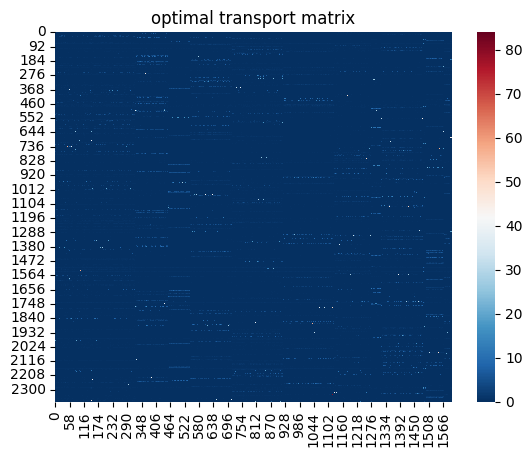

In [17]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [18]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterp

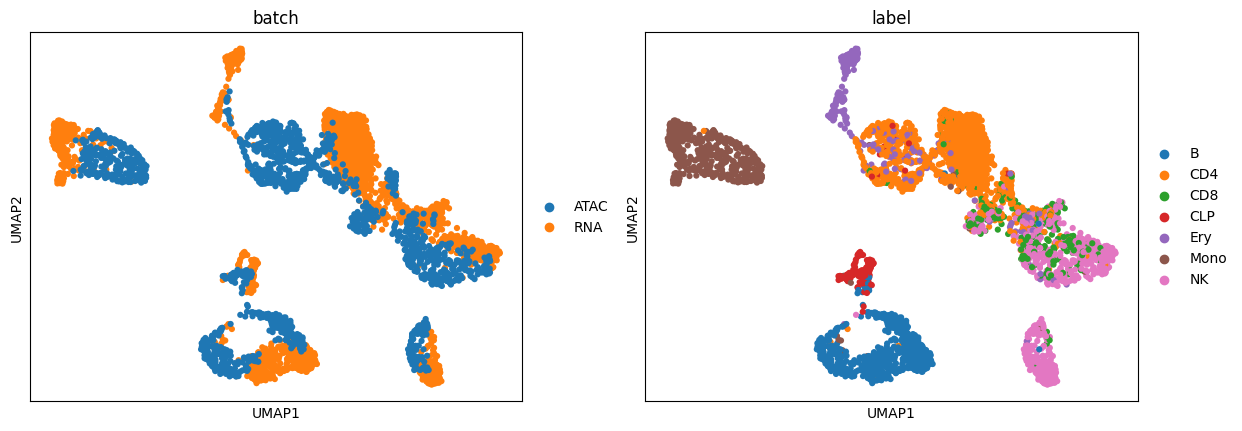

In [19]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n1 + ['ATAC'] * n2)
adata_aligned.obs['label'] = np.concatenate((basic_labels1, basic_labels2),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch','label'],s = 80)

In [22]:
X1_aligned, X2_aligned = align(X1, X2, P, ajust=True)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

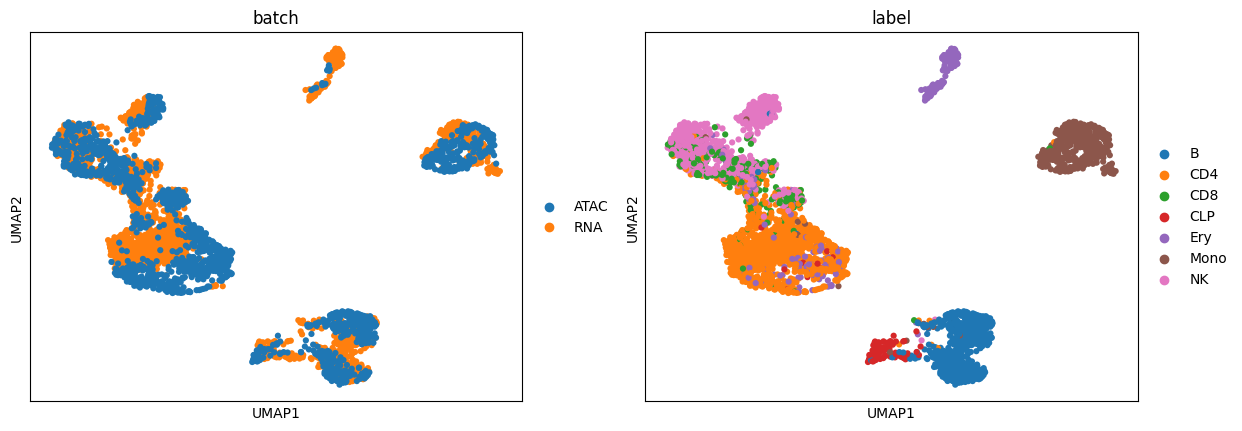

In [23]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n1 + ['ATAC'] * n2)
adata_aligned.obs['label'] = np.concatenate((basic_labels1, basic_labels2),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch','label'],s = 80)